In [1]:
import os
import sys
os.environ["BACKEND"] = "numpy"
# Set JAX backend if necessary (often not needed explicitly)
# os.environ["JAX_PLATFORM_NAME"] = "cpu" # or "gpu", "tpu"

script_dir = os.path.dirname(os.path.abspath(__file__)) if "__file__" in locals() else os.getcwd()
for i in range(1, 5): # Check up to 4 levels up
    dir_up = os.path.abspath(os.path.join(script_dir, *(['..'] * i)))
    if dir_up not in sys.path:
        sys.path.append(dir_up)
    sys.path.append(os.path.join(dir_up, "QES", "general_python"))

# try to import the gymnasium package, this is used to create a custom environment for quantum vector optimization
import gymnasium as gym
import jax
import jax.numpy as jnp
import numpy as np

import distrax
import optax
import flax.linen as nn
from typing import Callable, Tuple, List, Optional, Union
from flax.training.train_state import TrainState

# common utilities for logging
try:
    from QES.general_python.algebra.utils import JAX_AVAILABLE
    from QES.general_python.common.flog import Logger, get_global_logger
    from QES.general_python.common.directories import Directories
    from QES.Algebra.hamil_quadratic import QuadraticSelection
    from QES.general_python.physics.entropy import vn_entropy
    from QES.general_python.physics.entropy_jax import vn_entropy_jax
    from QES.general_python.physics.density_matrix import rho_numba, rho_numba_mask, schmidt_numba
    from QES.general_python.physics.density_matrix_jax import rho_jax, schmidt_jax
except ImportError as e:
    print(f"Error importing custom modules (QES, extractors): {e}")
    print("Please ensure these modules are in the Python path and are JAX-compatible.")
    sys.exit(1)

#! Global Configuration & Initialization

# For reproducibility
master_seed     = np.random.randint(0, 2**32 - 1) 
# master_seed = 42 # Or set a fixed seed
key             = jax.random.PRNGKey(master_seed)
np.random.seed(master_seed)

# Logger setup
logger          = get_global_logger()

06_06_2025_23-26_29 [INFO] Log file created: ./log/QES_06_06_2025_23-26_29.log
06_06_2025_23-26_29 [INFO] Log level set to: info
06_06_2025_23-26_29 [INFO] ############Global logger initialized.############
06_06_2025_23-26_29 [INFO] JAX is not available. Using NumPy as the active backend.
06_06_2025_23-26_29 [INFO] **************************************************
06_06_2025_23-26_29 [INFO] Backend Configuration:
06_06_2025_23-26_29 [INFO] 		NumPy Version: 2.1.3
06_06_2025_23-26_29 [INFO] 		SciPy Version: 1.15.2
06_06_2025_23-26_29 [INFO] 		JAX Version: Not Available
06_06_2025_23-26_29 [INFO] 		Active Backend: numpy
06_06_2025_23-26_29 [INFO] 			JAX Available: False
06_06_2025_23-26_29 [INFO] 			Default Seed: 42
06_06_2025_23-26_29 [INFO] 		NumPy Backend Details:
06_06_2025_23-26_29 [INFO] 				Main Module: numpy
06_06_2025_23-26_29 [INFO] 				Random Module: Generator
06_06_2025_23-26_29 [INFO] 				SciPy Module: scipy
06_06_2025_23-26_29 [INFO] 		Active Data Types:
06_06_2025_23-26_2

In [2]:
# Parameters for data selection
gamma_select    = 10
ns              = 12
dim_a           = 2**(ns // 2)
dim_b           = 2**(ns // 2)
org_nh          = 2**ns
logger.info(f"Using master seed: {master_seed}")
logger.info(f"Gamma selection: {gamma_select}, ns: {ns}, dim_a: {dim_a}, dim_b: {dim_b}, org_nh: {org_nh}", color ="green")

06_06_2025_23-25_53 [INFO] Using master seed: 1608637542
06_06_2025_23-25_53 [INFO] Gamma selection: 10, ns: 12, dim_a: 64, dim_b: 64, org_nh: 4096


In [3]:
base_data_dir   = os.path.join(script_dir, 'data')
directory_org   = Directories(os.path.join(base_data_dir, 'org'))
directory_mix   = Directories(os.path.join(base_data_dir, 'mix'))

# Check for data directories
if not directory_org.exists():
    logger.error(f"Data directory not found: {directory_org.path_itself}")
    sys.exit(1)
if not directory_mix.exists():
    logger.error(f"Data directory not found: {directory_mix.path_itself}")
    sys.exit(1)

files_org       = directory_org.list_files(filters=[lambda x: str(x).endswith('.npy')])
files_mix       = directory_mix.list_files(filters=[lambda x: str(x).endswith('.npy')])

def get_random_matching_files(files_org_list, files_mix_list, gamma_val, ns_val):
    # Filter org files
    org_candidates = [str(f) for f in files_org_list if f'gamma={gamma_val}' in str(f) and f'ns={ns_val}' in str(f)]
    if not org_candidates:
        raise ValueError(f"No ORG files found with gamma={gamma_val} and ns={ns_val}.")
    
    selected_org_file = str(np.random.choice(org_candidates))
    
    # Try to find a corresponding mix file. This logic assumes a naming convention.
    # The same name is there
    selected_mix_file = selected_org_file.replace('org', 'mix')
    logger.info(f"Selected ORG file: {selected_org_file} (from {len(org_candidates)} matches)")
    logger.info(f"Selected MIX file: {selected_mix_file} (should match ORG file naming convention)")
    return selected_org_file, selected_mix_file

try:
    random_file_org_path, random_file_mix_path = get_random_matching_files(files_org, files_mix, gamma_select, ns)
    
    logger.info(f"Loading original data from: {random_file_org_path}")
    data_org        = np.load(random_file_org_path)
    logger.info(f"Loading mixed data from: {random_file_mix_path}")
    data_mix        = np.load(random_file_mix_path)
    data_org_jax    = jnp.array(data_org)
    data_mix_jax    = jnp.array(data_mix)
    
except (FileNotFoundError, ValueError) as e:
    logger.error(f"Error during data loading/selection: {e}")
    sys.exit(1)

logger.info(f"Loaded data_org_jax with shape: {data_org_jax.shape}", lvl = 1, color = 'green')
logger.info(f"Loaded data_mix_jax with shape: {data_mix_jax.shape}", lvl = 1, color = 'green')

if data_mix_jax.shape[0] != org_nh:
    logger.error(f"Mismatch: data_mix_jax rows ({data_mix_jax.shape[0]}) != org_nh ({org_nh}).")
    sys.exit(1)

if data_mix_jax.shape[1] != gamma_select:
    logger.error(f"Mismatch: data_mix_jax columns ({data_mix_jax.shape[1]}) != gamma_select ({gamma_select}).")
    logger.error("The number of columns in mixed data (component states) must match gamma_select.")
    sys.exit(1)

logger.info("Calculating initial entanglement for a few original states (from data_org_jax):")

# Calculate entanglement for the first few original states
num_states_to_check     = min(data_org_jax.shape[1], 10)
gamma                   = data_org_jax.shape[1]
entropy_values          = {
    'original'      : [],
    'mixed'         : [],
    'minimum'       : float('inf'),
    'maximum'       : float('-inf'),
    'minimum_mixed' : float('inf'),
    'maximum_mixed' : float('-inf'),
    'average'       : 0.0,
    'average_mixed' : 0.0
}

for i in range(gamma):
    state               = data_org_jax[:, i]
    state_norm_val      = jnp.linalg.norm(state)
    schmidt_values, _   = schmidt_jax(state, dim_a, dim_b, use_eig=False)       # these already return schmidt values
    entropy             = vn_entropy_jax(schmidt_values)                        # calculate von Neumann entropy
    entropy_values['original'].append(entropy)
    entropy_values['minimum']   = min(entropy_values['minimum'], entropy)
    entropy_values['maximum']   = max(entropy_values['maximum'], entropy)
    entropy_values['average']  += entropy / gamma
    if i < num_states_to_check:
        logger.info(f"State {i}: Entropy = {entropy:.5f}", color='blue')

# do the same for mixed states
for i in range(gamma):
    state               = data_mix_jax[:, i]
    state_norm_val      = jnp.linalg.norm(state)
    schmidt_values, _   = schmidt_jax(state, dim_a, dim_b, use_eig=False)       # these already return schmidt values
    entropy             = vn_entropy_jax(schmidt_values)                        # calculate von Neumann entropy
    entropy_values['mixed'].append(entropy)
    entropy_values['minimum_mixed']   = min(entropy_values['minimum_mixed'], entropy)
    entropy_values['maximum_mixed']   = max(entropy_values['maximum_mixed'], entropy)
    entropy_values['average_mixed']  += entropy / gamma

logger.info(f"Entropy values for original states: {entropy_values['original'][:num_states_to_check]}")
logger.info(f"Minimum entropy: {entropy_values['minimum']:.5f}", color='blue', lvl = 1)
logger.info(f"Maximum entropy: {entropy_values['maximum']:.5f}", color='red', lvl = 1)
logger.info(f"Average entropy: {entropy_values['average']:.5f}", color='green', lvl = 1)
logger.info(f"Entropy values for mixed states: {entropy_values['mixed'][:num_states_to_check]}")
logger.info(f"Minimum mixed entropy: {entropy_values['minimum_mixed']:.5f}", color='blue', lvl = 1)
logger.info(f"Maximum mixed entropy: {entropy_values['maximum_mixed']:.5f}", color='red', lvl = 1)
logger.info(f"Average mixed entropy: {entropy_values['average_mixed']:.5f}", color='green', lvl = 1)

06_06_2025_23-25_54 [INFO] Selected ORG file: /Users/makskliczkowski/Codes/QuantumEigenSolver/Python/Projects/2025/degenerate_entanglement/reinforced/data/org/ff,E=4.46410,ns=12,gamma=10.npy (from 1 matches)
06_06_2025_23-25_54 [INFO] Selected MIX file: /Users/makskliczkowski/Codes/QuantumEigenSolver/Python/Projects/2025/degenerate_entanglement/reinforced/data/mix/ff,E=4.46410,ns=12,gamma=10.npy (should match ORG file naming convention)
06_06_2025_23-25_54 [INFO] Loading original data from: /Users/makskliczkowski/Codes/QuantumEigenSolver/Python/Projects/2025/degenerate_entanglement/reinforced/data/org/ff,E=4.46410,ns=12,gamma=10.npy
06_06_2025_23-25_54 [INFO] Loading mixed data from: /Users/makskliczkowski/Codes/QuantumEigenSolver/Python/Projects/2025/degenerate_entanglement/reinforced/data/mix/ff,E=4.46410,ns=12,gamma=10.npy
06_06_2025_23-25_54 [INFO] 	->Loaded data_org_jax with shape: (4096, 10)
06_06_2025_23-25_54 [INFO] 	->Loaded data_mix_jax with shape: (4096, 10)
06_06_2025_23-25

TypeError: 'NoneType' object is not callable

$$ H(x)=−x^2\log x^2−(1−x^2)\log(1−x^2) $$

In [74]:
def entanglement_loss_fn_for_env(coefficients: jnp.ndarray) -> jnp.ndarray:
    # coefficients: complex vector of shape (gamma_select,)
    # data_mix_jax: (org_nh, gamma_select), where each column is a basis state |psi_k_mix>
    demixed_state               = data_mix_jax[:, 0] * coefficients[0]  # Start with the first state
    for i in range(1, coefficients.shape[0]):
        demixed_state          += data_mix_jax[:, i] * coefficients[i]  # Add contributions from all states
    # Normalize the demixed state
    norm_demixed                = jnp.linalg.norm(demixed_state)
    demixed_state_normalized    = demixed_state / (norm_demixed)        # Ensure normalization for physical state
    
    # Calculate the entanglement entropy of the demixed state
    schmidt_values_demixed, _   = schmidt_jax(demixed_state_normalized, dim_a, dim_b, use_eig=False) # already returns schmidt values
    entropy_demixed             = vn_entropy_jax(schmidt_values_demixed)
    return entropy_demixed

entanglement_loss_calculator_jit = jax.jit(entanglement_loss_fn_for_env)

### Test the entanglement entropies

In [76]:
#! Test the entanglement loss function with equal coefficients
# coefficients_uniform    = jnp.array([1] + [0] * (gamma - 1))
coefficients_uniform    = jnp.ones(data_mix_jax.shape[1])
coefficients_uniform_n  = jnp.linalg.norm(coefficients_uniform)
coefficients_uniform    = coefficients_uniform / coefficients_uniform_n
logger.info(f"Testing entanglement loss with uniform coefficients... Norm={jnp.linalg.norm(coefficients_uniform):.5f}", lvl=2, color='green')
entanglement_loss_test  = entanglement_loss_calculator_jit(coefficients_uniform)
logger.info(f"Entropy of the demixed state with uniform coefficients: {entanglement_loss_test:.5f}", lvl=3, color='green')
logger.info(f"Original entropy averaged with uniform probabilities: {np.dot(entropy_values['original'], coefficients_uniform**2)}", lvl=3, color='green')

coefficients_random     = jax.random.uniform(key = key, shape=(data_mix_jax.shape[1],))
coefficients_random_n   = jnp.linalg.norm(coefficients_random)
coefficients_random     = coefficients_random / coefficients_random_n
logger.info(f"Testing entanglement loss with random coefficients... Norm={jnp.linalg.norm(coefficients_random):.5f}", lvl=2, color='red')
entanglement_loss_test  = entanglement_loss_calculator_jit(coefficients_random)
logger.info(f"Entropy of the demixed state with random coefficients: {entanglement_loss_test:.5f}", lvl=3, color='red')
logger.info(f"Original entropy averaged with random probabilities: {np.dot(entropy_values['original'], coefficients_random**2)}", lvl=3, color='red')

05_06_2025_11-07_20 [INFO] 		->Testing entanglement loss with uniform coefficients... Norm=1.00000
05_06_2025_11-07_20 [INFO] 			->Entropy of the demixed state with uniform coefficients: 2.56221
05_06_2025_11-07_20 [INFO] 			->Original entropy averaged with uniform probabilities: 2.0420737266540527
05_06_2025_11-07_20 [INFO] 		->Testing entanglement loss with random coefficients... Norm=1.00000
05_06_2025_11-07_20 [INFO] 			->Entropy of the demixed state with random coefficients: 2.55153
05_06_2025_11-07_20 [INFO] 			->Original entropy averaged with random probabilities: 2.0543389320373535


05_06_2025_11-11_48 [INFO] 		->Entropy distribution: mean=2.45784, std=0.09773
05_06_2025_11-11_48 [INFO] 		->Minimum entropy in distribution: 1.96507
05_06_2025_11-11_48 [INFO] 		->Maximum entropy in distribution: 2.76414


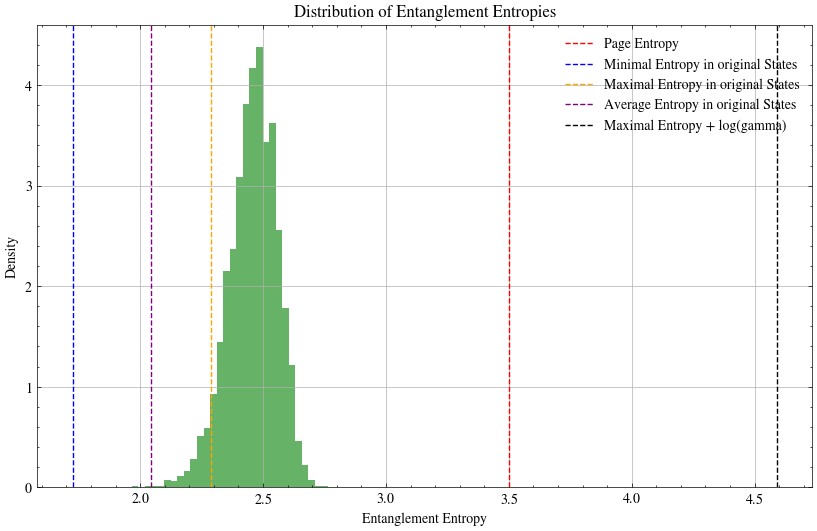

In [ ]:
# create the distribution of the entanglement entropies
n_samples = 500
gamma     = data_mix_jax.shape[1]           # Number of coefficients (Gamma)
docoeffs  = False
if docoeffs:
    logger.info(f"Using {gamma} coefficients for entanglement entropy distribution calculation.", lvl=2, color='purple')
    entropies = np.zeros(n_samples)         # Array to store entanglement entropies
else:
    entropies = np.zeros(gamma * n_samples) # Array to store entanglement entropies

for i in range(n_samples):
    if docoeffs:
        coefficients    = np.random.normal(size=(gamma,)) + 1j * np.random.normal(size=(gamma,)) # Ensure complex coefficients
        coefficients_n  = np.linalg.norm(coefficients)
        coefficients    = coefficients / (coefficients_n + 1e-11)
        entropies[i]    = entanglement_loss_calculator_jit(coefficients)
    else:
        haar_unitary    = jnp.array(QuadraticSelection.haar_random_unitary(gamma=gamma))
        states          = data_mix_jax @ haar_unitary
        for j in range(gamma):
            schmidt, _                  = schmidt_jax(states[:, j], dim_a, dim_b, use_eig=False) 
            entropies[i * gamma + j]    = vn_entropy_jax(schmidt)
logger.info(f"Entropy distribution: mean={np.mean(entropies):.5f}, std={np.std(entropies):.5f}", lvl=2, color='purple')
logger.info(f"Minimum entropy in distribution: {np.min(entropies):.5f}", lvl=2, color='blue')
logger.info(f"Maximum entropy in distribution: {np.max(entropies):.5f}", lvl=2, color='red')

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(entropies, bins=30, density=True, alpha=0.6, color='g')
plt.xlabel('Entanglement Entropy')
plt.ylabel('Density')
plt.title('Distribution of Entanglement Entropies')
plt.grid()
plt.axvline(x = np.log(2) * ns // 2 - 0.5, color='r',       linestyle='--', label='Page Entropy')
plt.axvline(x = entropy_values['minimum'], color='b',       linestyle='--', label='Minimal Entropy in original States')
plt.axvline(x = entropy_values['maximum'], color='orange',  linestyle='--', label='Maximal Entropy in original States')
plt.axvline(x = entropy_values['average'], color='purple',  linestyle='--', label='Average Entropy in original States')
plt.axvline(x = entropy_values['maximum'],  color='black', linestyle='--', label='Maximal Entropy + log(gamma)')
plt.legend()

## Learn!

In [ ]:
class QuantumVectorEnv(gym.Env):
    
    metadata = {'render_modes': ['human'], 'render_fps': 30}

    def __init__(self, 
                gamma_dim           : int,
                angle_list          : List[float],
                loss_calculator     : Callable[[jnp.ndarray], jnp.ndarray],
                reg_lambda_norm     : float = 0.1, initial_coeffs: jnp.ndarray = None):
        super().__init__()
        
        if gamma_dim < 2: raise ValueError("Gamma dimension must be at least 2.")
        if not angle_list: raise ValueError("Angle list cannot be empty.")
        
        self.gamma_dim = gamma_dim
        self.angles = jnp.array(angle_list, dtype=jnp.float32)
        self.num_angles = len(angle_list)
        self.loss_calculator = loss_calculator # Function that returns scalar JAX array (e.g., entropy)
        self.reg_lambda_norm = reg_lambda_norm
        self.initial_coeffs_template = initial_coeffs

        self.action_space = gymnasium.spaces.Discrete(int((gamma_dim * (gamma_dim - 1) // 2) * self.num_angles))
        self.observation_space = gymnasium.spaces.Box(low=-1.0, high=1.0, shape=(2 * gamma_dim,), dtype=np.float32)

        self.coeffs_state: jnp.ndarray = None # Stores the complex coefficient vector c
        self.current_loss_value: jnp.ndarray = None
        self.rng_internal = None # JAX PRNG key for this env instance

    def reset(self, seed: int = None, options: Dict = None):
        super().reset(seed=seed)
        
        if seed is None: # Create a new seed if none provided
            seed = np.random.randint(0, 2**32 - 1)
        self.rng_internal = jax.random.PRNGKey(seed)

        if self.initial_coeffs_template is not None:
            coeffs = jnp.array(self.initial_coeffs_template, dtype=jnp.complex64)
            if coeffs.shape != (self.gamma_dim,):
                raise ValueError(f"Initial coeffs shape {coeffs.shape} != ({self.gamma_dim},)")
            coeffs_norm = jnp.linalg.norm(coeffs)
            if not jnp.isclose(coeffs_norm, 1.0):
                logger.warning(f"Provided initial coeffs norm is {coeffs_norm:.4f}. Normalizing.")
                coeffs = coeffs / (coeffs_norm + 1e-8)
        else:
            key_real, key_imag = jax.random.split(self.rng_internal)
            c_real = jax.random.normal(key_real, (self.gamma_dim,))
            c_imag = jax.random.normal(key_imag, (self.gamma_dim,))
            coeffs = c_real + 1j * c_imag
            coeffs = coeffs / (jnp.linalg.norm(coeffs) + 1e-8)
        
        self.coeffs_state = coeffs
        self.current_loss_value = self.loss_calculator(self.coeffs_state)
        
        info = {'initial_loss': self.current_loss_value.item()}
        return self._get_obs(), info

    def step(self, action: int):
        idx_i, idx_j, angle_idx = self._decode_action(action)
        theta_rot = self.angles[angle_idx]
        
        self.coeffs_state = self._apply_rotation(self.coeffs_state, idx_i, idx_j, theta_rot)
        
        current_norm_sq = jnp.sum(jnp.abs(self.coeffs_state)**2)
        norm_penalty_val = jnp.abs(1.0 - current_norm_sq)
        
        # Renormalize coefficients to prevent drift, if desired, then penalty is less critical
        # self.coeffs_state = self.coeffs_state / (jnp.sqrt(current_norm_sq) + 1e-8)
        # norm_penalty_val = 0.0 # If re-normalizing state

        self.current_loss_value = self.loss_calculator(self.coeffs_state) # This is the entanglement S_E
        # Reward: we want to MINIMIZE S_E. So, reward = -S_E. Also penalize norm deviation.
        reward = -self.current_loss_value - self.reg_lambda_norm * norm_penalty_val
        
        terminated = False # Episode is infinite horizon unless other conditions are set
        truncated = False 

        info = {
            'loss': self.current_loss_value.item(), 
            'norm_penalty': norm_penalty_val.item(),
            'coeff_norm_sq': current_norm_sq.item()
        }
        return self._get_obs(), reward.item(), terminated, truncated, info

    def _apply_rotation(self, c_vec: jnp.ndarray, i: int, j: int, theta: jnp.ndarray) -> jnp.ndarray:
        ci, cj = c_vec[i], c_vec[j]
        cos_t, sin_t = jnp.cos(theta), jnp.sin(theta)
        
        # SU(2) rotation on (ci, cj) subspace. This is a real rotation matrix.
        # If complex phases are desired in rotation: R = [[cos(t), -e^(i*phi)sin(t)], [e^(-i*phi)sin(t), cos(t)]]
        # For now, using the provided real rotation.
        ci_new = cos_t * ci - sin_t * cj
        cj_new = sin_t * ci + cos_t * cj
        
        return c_vec.at[i].set(ci_new).at[j].set(cj_new)

    def _decode_action(self, action_flat: int) -> Tuple[int, int, int]:
        pair_idx = action_flat // self.num_angles
        angle_table_idx = action_flat % self.num_angles

        current_pair_count = 0
        for i in range(self.gamma_dim):
            for j in range(i + 1, self.gamma_dim):
                if current_pair_count == pair_idx:
                    return i, j, angle_table_idx
                current_pair_count += 1
        raise ValueError(f"Invalid action {action_flat} decoded to invalid pair_idx {pair_idx}")

    def _get_obs(self) -> np.ndarray: # Must return np.ndarray
        obs_complex_flat = jnp.concatenate([jnp.real(self.coeffs_state), jnp.imag(self.coeffs_state)])
        return np.array(obs_complex_flat, dtype=np.float32)

    def render(self, mode='human'):
        if mode == 'human':
            norm_sq = jnp.sum(jnp.abs(self.coeffs_state)**2).item()
            loss_val_str = f"{self.current_loss_value.item():.5f}" if self.current_loss_value is not None else "N/A"
            print(f"Coeffs Norm^2: {norm_sq:.5f}, Loss (Entanglement): {loss_val_str}")

In [105]:

class QuantumVectorEnv(gym.Env):
    """
    A Gymnasium environment for optimizing a complex normalized vector using pairwise unitary rotations.
    """

    def __init__(self,  
                gamma       : int,
                angles      : list,
                loss_fn     : Callable[[jnp.ndarray], float],
                reg_lambda  : float = 10.0):
        '''
        Initializes the QuantumVectorEnv environment.
        
        Parameters:
        
            gamma (int):
                Dimension of the complex vector that constitutes the quantum states (in any basis, with a specific Hilbert space dimension).
                The states are represented as complex vectors of size gamma, such that:
                \psi = \sum _i c_i |\phi _i \rangle, where \vec{c} \in \mathbb{C}^N, and \sum _i |c_i|^2 = 1. 
                Also, |phi _i> = \sum _k \phi _i^k |k \rangle, where \phi _i^k are the basis states in the computational basis.
            angles (list):
                List of discrete rotation angles in radians.
            loss_fn (Callable[[jnp.ndarray], float]):
                A function that takes the current state as input and returns a scalar loss value. This is meant to be 
                an entanglement black-box that can take coefficients (\Gamma-dimensional complex vector) and return a scalar loss value
                based on combining the states in an arbitrary basis according to the coefficients.
            reg_lambda (float):
                Regularization strength for the norm penalty. The norm penalty is applied to encourage the state vector to remain normalized.
                Default is 10.0.
            norm_instead_of_penal (bool):
                If True, the state is normalized instead of penalized. This means that the state will always remain normalized,
                and the loss function will not include a norm penalty term. Default is False.
        Raises:
            ValueError: If gamma is less than 2 or angles is empty.

        '''
        if gamma < 2:
            raise ValueError("Gamma must be at least 2 to allow for pairwise rotations.")
        
        if not angles or not isinstance(angles, list) or not all(isinstance(angle, (int, float)) for angle in angles):
            raise ValueError("Angles must be a non-empty list of numeric values (radians).")
        
        #! Initialize the environment with the given parameters.
        super().__init__()
        
        self.gamma              = gamma                 # Dimension of the complex vector
        self.angles             = jnp.array(angles)     # List of discrete angles that one can use to rotate the vector (in radians)
        self.num_angles         = len(angles)
        self.loss_fn            = loss_fn               # Black-box loss function
        self.reg_lambda         = reg_lambda            # Regularization strength for the norm penalty

        # action space is defined as the number of unique pairs (i, j) with i < j multiplied by the number of angles,
        # it allows to choose a pair of indices (i, j) to apply a rotation and the angle of rotation
        self.action_space       = gym.spaces.Discrete((gamma * (gamma - 1) // 2) * self.num_angles)
        
        # observation space is a flattened complex vector of size 2 * gamma (real and imaginary parts)
        self.observation_space  = gym.spaces.Box(low=-1.0, high=1.0, shape=(2 * gamma,), dtype=np.float32) 

        self.state              = None
        self.seed               = None
        self.rng                = None
        self.norm_inst_of_penal = False                 # Flag to indicate if the norm penalty is applied as an instance of the loss function
        self.reset()

    def reset(self, 
            seed    = None, 
            options = None):
        '''
        Resets the environment to an initial state. It creates a random normalized complex vector of size gamma.
        
        TODO: Implement options for resetting the environment, such as setting a specific initial state or parameters. 
        Allow for more flexibility in resetting the environment and add Haar randomization options.
        
        Parameters:
            seed (int, optional):
                Random seed for reproducibility. If None, a random seed is generated.
            options (dict, optional):
                Additional options for resetting the environment (not used in this implementation).
        Returns:
            Tuple of (observation, info):
                - observation: The initial state of the environment as a flattened complex vector.
                - info: An empty dictionary for additional information (not used in this implementation).
        
        '''
        if seed is None:
            self.seed = np.random.randint(0, 2**32)
        else:
            self.seed = seed
        self.rng    = jax.random.PRNGKey(self.seed)
        v_real      = jax.random.normal(self.rng, (self.gamma,)) # create a vector of real parts
        v_imag      = jax.random.normal(self.rng, (self.gamma,)) # create a vector of imaginary parts 
        v           = v_real + 1j * v_imag
        v          /= jnp.linalg.norm(v)
        self.state  = v # make the state a normalized complex vector
        return self._get_obs(), {}

    #############################
    #! Single step interaction with the environment
    #############################    

    def step(self, action):
        
        # Decode the action to get indices and angle
        i, j, theta_idx     = self._decode_action(action)
        # Theta is the angle of rotation to apply
        theta               = self.angles[theta_idx]
        # Update the state by applying the rotation
        self.state          = self._apply_rotation(self.state, i, j, theta)

        # Compute the norm penalty
        norm_penalty        = jnp.abs(1.0 - jnp.sum(jnp.abs(self.state) ** 2)) if (not self.norm_inst_of_penal) else 0.0
        reward              = -self.loss_fn(self.state) - self.reg_lambda * norm_penalty
        done                = False
        
        # Return the observation, reward, done flag, and additional info
        return self._get_obs(), reward.item(), done, False, {}

    #############################
    #! Helper methods for the environment
    #############################

    def _apply_rotation(self, v: jnp.ndarray, i: int, j: int, theta: float) -> jnp.ndarray:
        '''
        Applies a pairwise rotation to the complex vector v at indices i and j using the angle theta.
        The rotation is a real-valued SU(2) rotation in the 2D subspace spanned by the indices i and j.
        
        Parameters:
            v (jnp.ndarray):
                The complex vector to which the rotation is applied.
            i (int):
                The first index of the pair to apply the rotation.
            j (int):
                The second index of the pair to apply the rotation.
            theta (float):
                The angle of rotation in radians.
        Returns:
            jnp.ndarray:
                The updated complex vector after applying the rotation.
        '''
        
        # choose the indices i and j to apply the rotation
        vi, vj      = v[i], v[j]
        cos_theta   = jnp.cos(theta)
        sin_theta   = jnp.sin(theta)

        # Real-valued SU(2) rotation in the 2D subspace
        vi_new      = cos_theta * vi - sin_theta * vj
        vj_new      = sin_theta * vi + cos_theta * vj

        v           = v.at[i].set(vi_new)
        v           = v.at[j].set(vj_new)
        return v

    def _decode_action(self, action: int):
        '''
        Decodes the action index into the corresponding pair of indices (i, j) and angle index.
        The action is a flat index that represents a unique pair of indices (i, j) with i < j, and an angle index.
        The action space is defined as the number of unique pairs (i, j) with i < j multiplied by the number of angles.
        
        Parameters:
            action (int):
                The action index to decode.
        Returns:
            Tuple of (i, j, theta_idx):
                - i (int): First index of the pair.
                - j (int): Second index of the pair.
                - theta_idx (int): Index of the angle to apply.
        '''
        # Decode the action into indices and angle index
        ij_idx      = action // self.num_angles
        theta_idx   = action % self.num_angles

        # Map flat index to upper-triangle (i < j)
        count       = 0
        for i in range(self.N):
            for j in range(i + 1, self.N):
                if count == ij_idx:
                    return i, j, theta_idx
                count += 1
        raise ValueError("Invalid action index")

    def _get_obs(self):
        '''
        Returns the current state as a flattened complex vector, concatenating the real and imaginary parts.
        
        Returns:
            jnp.ndarray:
                The current state as a flattened complex vector of size 2 * gamma (real and imaginary parts).
        '''
        return jnp.concatenate([jnp.real(self.state), jnp.imag(self.state)]).astype(jnp.float32)

    def render(self):
        print("State norm:", jnp.sum(jnp.abs(self.state) ** 2))
        print("State:", self.state)

##################################
#! PPO Agent for QuantumVectorEnv
##################################

class ActorCritic(nn.Module):
    action_dim: int

    @nn.compact
    def __call__(self, x):
        '''
        Defines a simple forward pass of the actor-critic model.
        The model consists of two dense layers with tanh activation, followed by two output layers:
        
        - logits: Output layer for action probabilities (logits).
        - value: Output layer for state value estimation.
        Parameters:
            x (jnp.ndarray):
                Input tensor representing the state of the environment.
        Returns:
            Tuple of (logits, value):
                - logits (jnp.ndarray): Output tensor representing action probabilities.
                - value (jnp.ndarray): Output tensor representing state value estimation.
        '''
        x       = nn.Dense(128)(x)
        x       = nn.tanh(x)
        x       = nn.Dense(128)(x)
        x       = nn.tanh(x)
        logits  = nn.Dense(self.action_dim)(x)
        value   = nn.Dense(1)(x)
        return logits, value.squeeze(-1)

##################################
#! TrainState for PPO
##################################

class PPOTrainState(TrainState):
    apply_fn: Callable = None

##################################
#! Utility functions for PPO
##################################

def select_action(params, apply_fn, obs, key):
    """
    Selects an action based on the current policy and state observation.
    
    Parameters:
        params: 
            The parameters of the actor-critic model.
        apply_fn:
            The function to apply the model to get logits and value.
        obs:
            The current state observation.
        key:
            JAX random key for sampling.
    
    Returns:
        Tuple of (action, log_prob, value):
            - action: The selected action.
            - log_prob: The log probability of the selected action.
            - value: The estimated value of the current state.
    """
    logits, value   = apply_fn({'params': params}, obs)
    dist            = distrax.Categorical(logits=logits)
    action          = dist.sample(seed=key)
    log_prob        = dist.log_prob(action)
    return action, log_prob, value

def compute_gae(rewards, values, dones, gamma=0.99, lam=0.95):
    """
    Computes Generalized Advantage Estimation (GAE) for Proximal Policy Optimization.
    
    Parameters:
        rewards (array):
            Array of rewards for each timestep
        values (array):
            Array of value estimates for each timestep (including next state)
        dones (array):
            Array of done flags for each timestep
        gamma (float):
            Discount factor for future rewards
        lam (float):
            Lambda parameter for GAE
        
    Returns:
        Tuple of (advantages, returns):
            - advantages: Calculated advantage values
            - returns: Calculated returns (advantages + values)
    """
    advantages  = []
    gae         = 0
    for t in reversed(range(len(rewards))):
        delta   = rewards[t] + gamma * values[t+1] * (1 - dones[t]) - values[t]
        gae     = delta + gamma * lam * (1 - dones[t]) * gae
        advantages.insert(0, gae)
    returns = advantages + values[:-1]
    return jnp.array(advantages), jnp.array(returns)

##################################
#! PPO Loss Function
##################################

@jax.jit
def ppo_loss_fn(params, apply_fn, obs, actions, log_probs_old, advantages, returns, clip_eps):
    logits, values  = apply_fn({'params': params}, obs)
    dist            = distrax.Categorical(logits=logits)
    log_probs       = dist.log_prob(actions)

    ratio           = jnp.exp(log_probs - log_probs_old)
    clipped_ratio   = jnp.clip(ratio, 1.0 - clip_eps, 1.0 + clip_eps)
    policy_loss     = -jnp.mean(jnp.minimum(ratio * advantages, clipped_ratio * advantages))

    value_loss      = jnp.mean((returns - values)**2)
    entropy_bonus   = jnp.mean(dist.entropy())

    loss            = policy_loss + 0.5 * value_loss - 0.01 * entropy_bonus
    return loss

##################################
#! Update Step for PPO
##################################

@jax.jit
def update_step(state: PPOTrainState, batch, clip_eps: float):
    grads = jax.grad(ppo_loss_fn)(  state.params, state.apply_fn,
                                    batch['obs'], 
                                    batch['actions'],
                                    batch['log_probs'], 
                                    batch['advantages'],
                                    batch['returns'], 
                                    clip_eps)
    return state.apply_gradients(grads=grads)

##################################

def create_train_state(rng      : jax.random.PRNGKey,
                    obs_dim     : int,
                    action_dim  : int,
                    lr          : float = 3e-4,
                    opt         : optax.GradientTransformation = optax.adam(3e-4)):
    model   = ActorCritic(action_dim=action_dim)
    params  = model.init(rng, jnp.ones((1, obs_dim)))['params']
    tx      = optax.chain(optax.clip_by_global_norm(0.5), opt)
    # Create the initial train state
    return PPOTrainState.create(apply_fn=model.apply, params=params, tx=tx)

<>:11: SyntaxWarning: invalid escape sequence '\p'
<>:11: SyntaxWarning: invalid escape sequence '\p'
/var/folders/7h/4tmv99_x2djdm97ys2h7mh5m0000gn/T/ipykernel_56017/1382171744.py:11: SyntaxWarning: invalid escape sequence '\p'
  '''


TypeError: non-default argument 'params' follows default argument

In [104]:
class VectorizedQuantumEnv:
    '''
    Wrapper for vectorized quantum environments.
    This class allows for parallel execution of multiple instances of the QuantumVectorEnv environment.
    It initializes a specified number of environments and provides methods to reset and step through them in parallel.
    
    Parameters:
        num_envs (int):
            Number of parallel environments to create.
        env_fn (Callable):
            Function that creates an instance of the QuantumVectorEnv environment.
    Raises:
        ValueError: If num_envs is less than 1 or env_fn is not callable.
    Usage:
        envs = VectorizedQuantumEnv(num_envs=8, env_fn=lambda: QuantumVectorEnv(gamma=4, angles=[0.1, 0.2, 0.3]))
        obs = envs.reset()
        actions = jnp.array([0, 1, 2, 3, 4, 5, 6, 7])
    
    '''
    def __init__(self, num_envs: int, env_fn: Callable):
        '''
        Initializes the VectorizedQuantumEnv with a specified number of environments.
        Parameters:
            num_envs (int):
                Number of parallel environments to create.
            env_fn (Callable):
                Function that creates an instance of the QuantumVectorEnv environment.
        Raises:
            ValueError: If num_envs is less than 1 or env_fn is not callable.
        '''
        self.envs       = [env_fn() for _ in range(num_envs)]
        self.num_envs   = num_envs

    def reset(self):
        obs = []
        for env in self.envs:
            o, _ = env.reset()
            obs.append(o)
        return jnp.stack(obs)

    def step(self, actions):
        obs, rewards, dones = [], [], []
        for env, a in zip(self.envs, actions):
            o, r, d, _, _ = env.step(int(a))
            if d:
                o, _ = env.reset()
            obs.append(o)
            rewards.append(r)
            dones.append(d)
        return jnp.stack(obs), jnp.array(rewards), jnp.array(dones)

###################################
#! Function to run a rollout in the vectorized quantum environment
###################################

def run_rollout(envs        : VectorizedQuantumEnv,
                state       : PPOTrainState, 
                rng         : jax.random.PRNGKey,
                rollout_len : int):
    
    num_envs    = envs.num_envs
    obs         = envs.reset()
    obs_list, actions, log_probs, rewards, dones, values = [], [], [], [], [], []

    # Go through the rollout length to collect data
    for _ in range(rollout_len):
        rng, key                = jax.random.split(rng)
        action, log_prob, value = select_action(state.params, state.apply_fn, obs, key)
        next_obs, reward, done  = envs.step(action)

        # Store the collected data
        obs_list.append(obs)
        actions.append(action)
        log_probs.append(log_prob)
        rewards.append(reward)
        dones.append(done)
        values.append(value)
        obs = next_obs

    #! After the loop, we need to compute the last value for the last observation
    last_value = select_action(state.params, state.apply_fn, obs, key)[2]
    values.append(last_value)

    #! reshape to (rollout_len * num_envs)
    def stack_flat(xlist):
        return jnp.reshape(jnp.stack(xlist), (-1,) + xlist[0].shape[1:])

    flat_rewards        = jnp.reshape(jnp.stack(rewards), (rollout_len, num_envs))
    flat_values         = jnp.stack(values)
    flat_dones          = jnp.reshape(jnp.stack(dones), (rollout_len, num_envs))
    advantages, returns = compute_gae(flat_rewards.T, flat_values.T, flat_dones.T)

    return {
        'obs'           : stack_flat(obs_list),
        'actions'       : stack_flat(actions),
        'log_probs'     : stack_flat(log_probs),
        'advantages'    : jnp.reshape(advantages.T, (-1,)),
        'returns'       : jnp.reshape(returns.T, (-1,))
    }, rng

def train_ppo(env_fn        : Callable, 
            total_steps     : int, 
            rollout_len     : int, 
            num_envs        : int = 8, 
            epochs          : int = 4,
            minibatch_size  : int = 64):
    envs        = VectorizedQuantumEnv(num_envs=num_envs, env_fn=env_fn)
    obs_dim     = envs.reset().shape[-1]
    action_dim  = envs.envs[0].action_space.n
    rng         = jax.random.PRNGKey(0)
    state       = create_train_state(rng, obs_dim, action_dim)

    steps_per_rollout = rollout_len * num_envs

    for step in range(0, total_steps, steps_per_rollout):
        # Run a rollout to collect data
        batch, rng = run_rollout(envs, state, rng, rollout_len)
        
        # Go through the epochs to update the model
        for _ in range(epochs):
            idxs = np.arange(steps_per_rollout)
            np.random.shuffle(idxs)
            
            for start in range(0, steps_per_rollout, minibatch_size):
                end     = start + minibatch_size
                mb_idx  = idxs[start:end]
                mbatch  = {k: v[mb_idx] for k, v in batch.items()}
                state   = update_step(state, mbatch, clip_eps=0.2)
    return state


NameError: name 'PPOTrainState' is not defined